# Tutorial 1: Pretraining TCRfoundation

This tutorial demonstrates how to pretrain the TCRfoundation model on large-scale paired TCR-transcriptome data.

## Overview
- Load and prepare pretraining data
- Train the foundation model with self-supervised learning
- Save the pretrained model and training history

## 1. Import Libraries

In [1]:
import numpy as np
import torch
import scanpy as sc
import pandas as pd
import tcrfoundation as tcrf

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

## 2. Load Pretraining Data

In [2]:
# Load preprocessed data
adata = sc.read("../data/adata_pretrain.h5ad")
print(f"Original dataset size: {adata.n_obs} cells")
print(f"Number of genes: {adata.n_vars}")
print(f"\nData contains:")
print(f"  - CDR3a sequences: {adata.obs['CDR3a'].notna().sum()}")
print(f"  - CDR3b sequences: {adata.obs['CDR3b'].notna().sum()}")

Original dataset size: 1780201 cells
Number of genes: 3000

Data contains:
  - CDR3a sequences: 1780201
  - CDR3b sequences: 1780201


## 3. Train Foundation Model

The model is trained with:
- **Contrastive learning**: Align gene expression and TCR representations
- **Gene expression reconstruction**: Predict masked gene expression
- **TCR sequence reconstruction**: Reconstruct masked TCR sequences

In [ ]:
print("\n=== Training foundation model ===")
foundation_model, history = tcrf.pretrain.train(
    adata, 
    epochs=2, # Just for demonstration. When training from scratch, please set the epoachs as 500.
    save_dir='../TCR_foundation_model',
    batch_size=2048,
    accumulation_steps=4,
    val_ratio=0.1,
    early_stopping_patience=50,
    max_length=30,
    add_special_tokens=True,
    warmup_epochs=10,
    improvement_threshold=1e-4
)

## 4. Save Training History

In [5]:
print("\nTraining complete!")
print(f"Best model saved to: ../TCR_foundation_model/foundation_model_best.pt")

# Save training history to CSV
df_loss = pd.DataFrame(history)
df_loss.to_csv('../TCR_foundation_model/pretrain_loss.csv', index=True)
print(f"Training history saved to: ../TCR_foundation_model/pretrain_loss.csv")


Training complete!
Best model saved to: ../TCR_foundation_model/foundation_model_best.pt
Training history saved to: ../TCR_foundation_model/pretrain_loss.csv


## 5. Visualize Training Progress

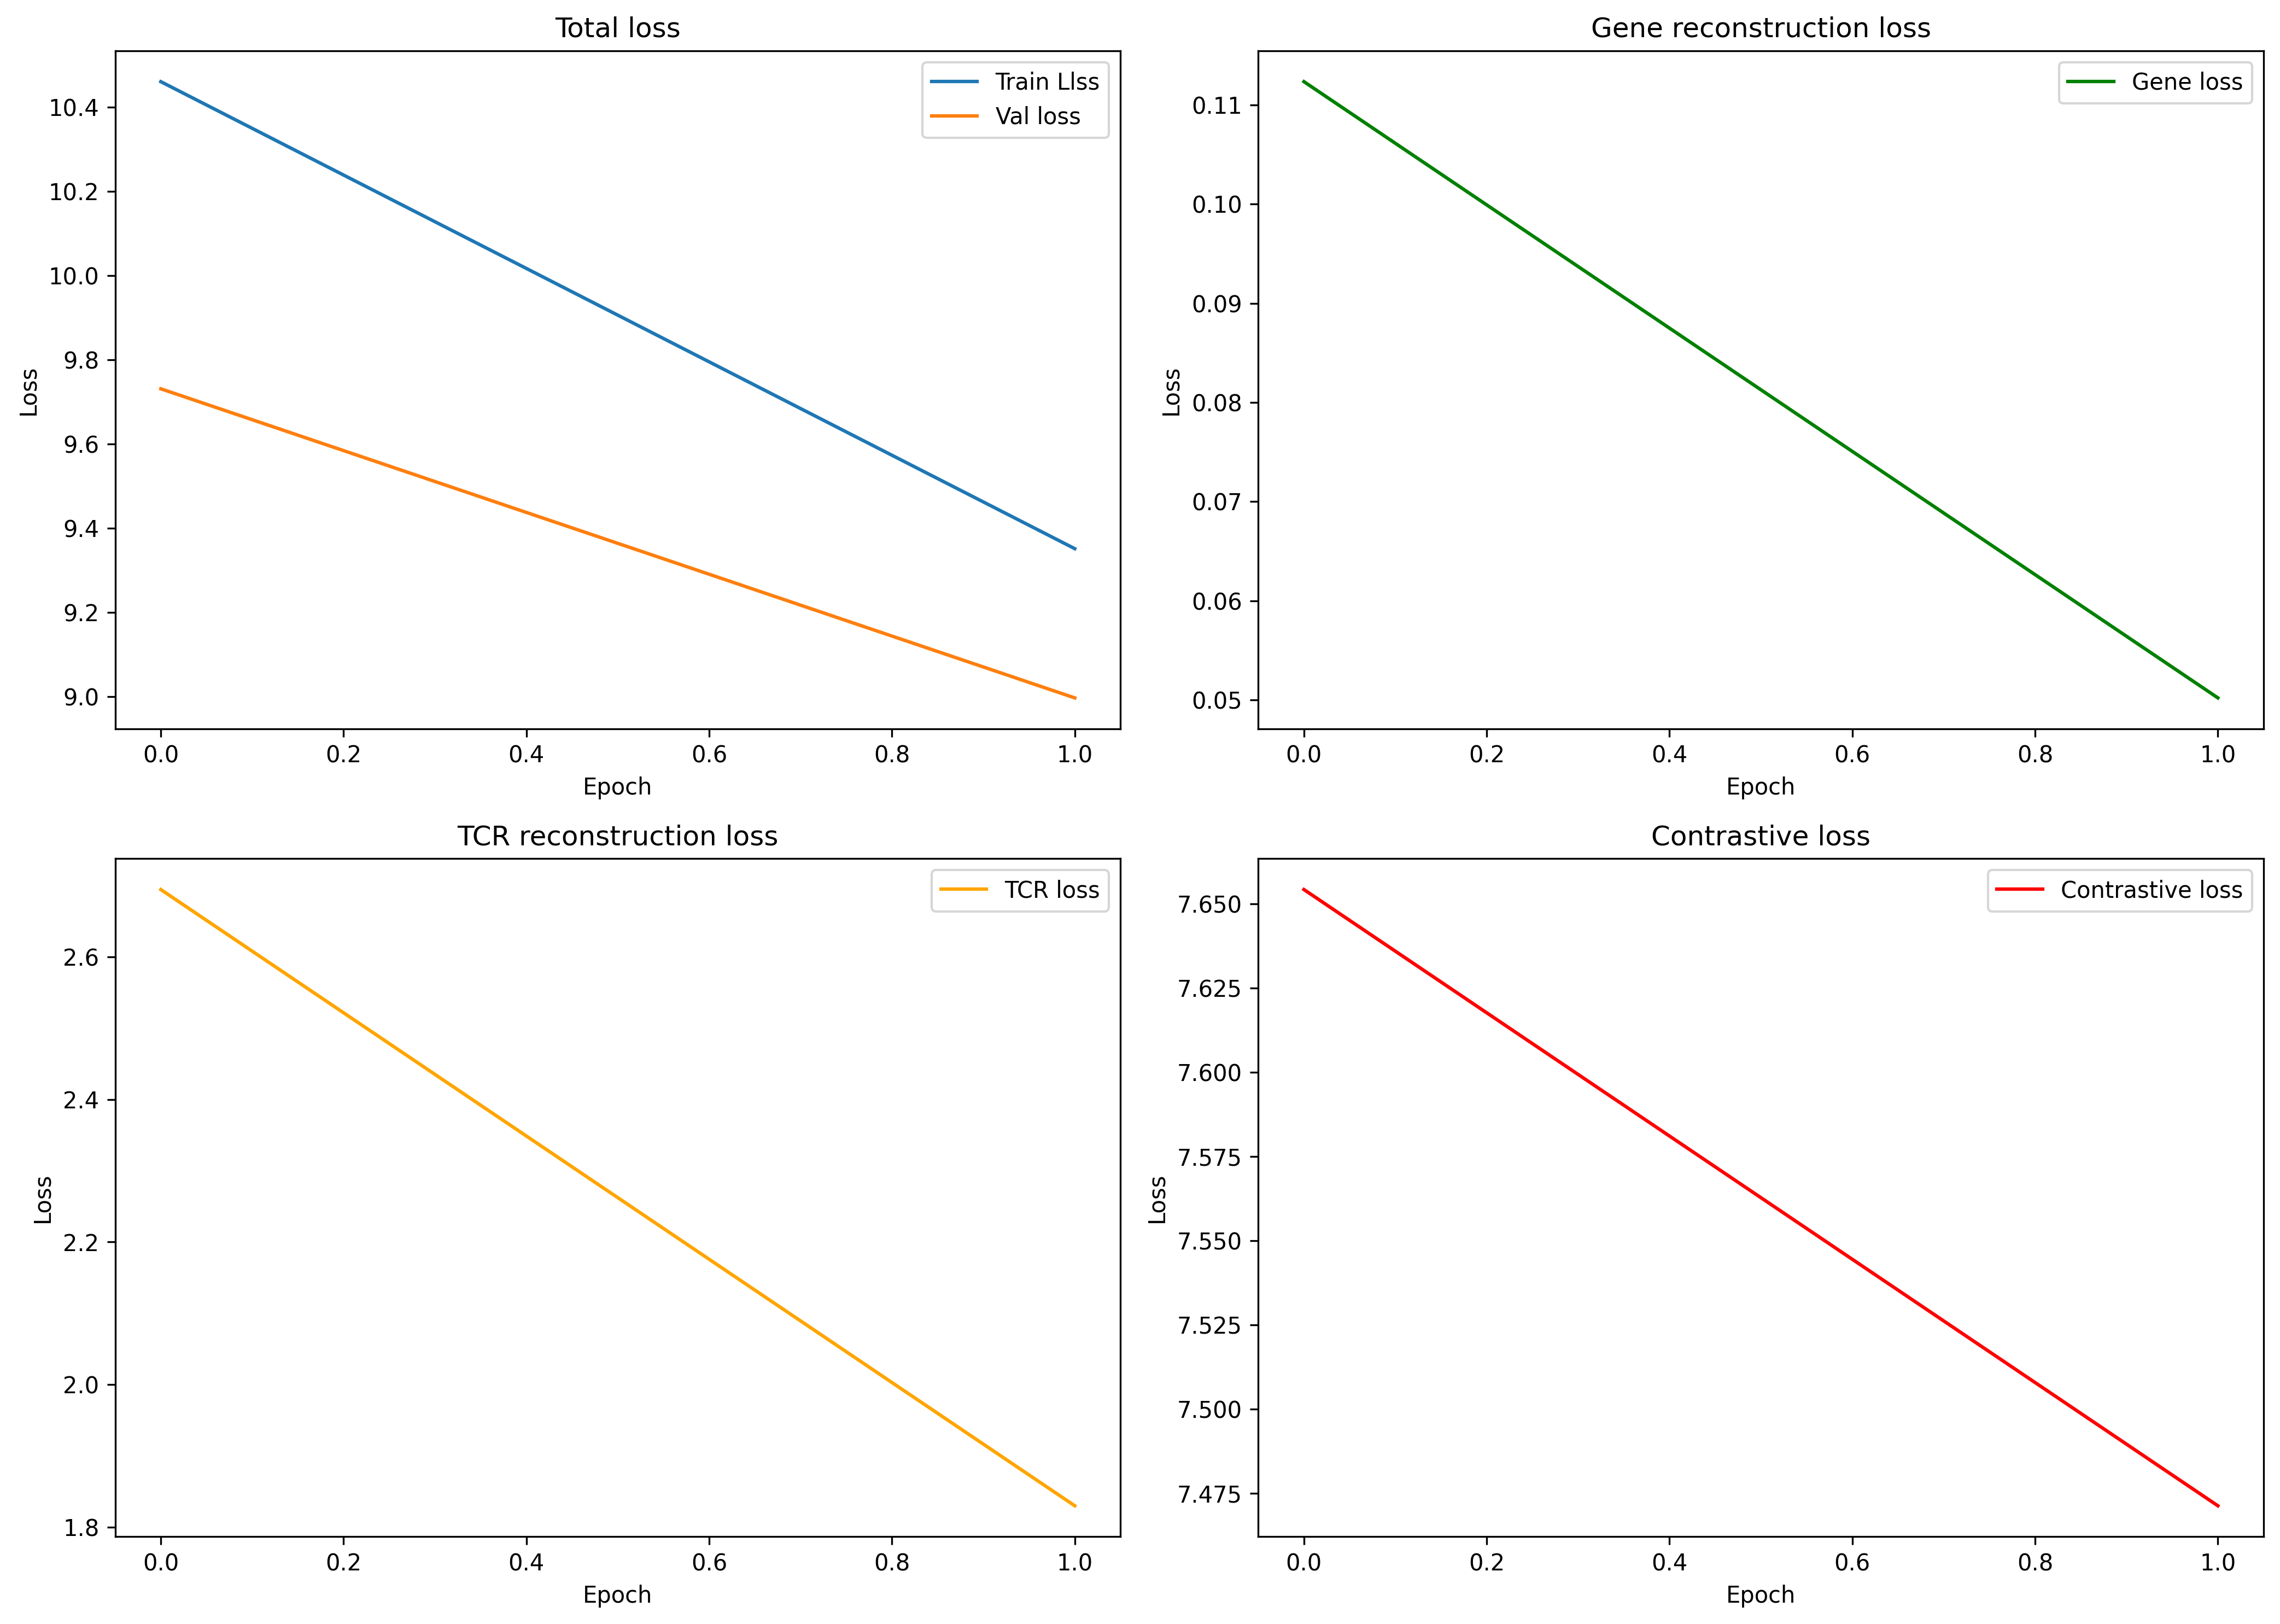

In [9]:
# Just for demonstration. Now there is only 2-epoach data.
import matplotlib.pyplot as plt

# Plot training and validation loss
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)

# Total loss
axes[0, 0].plot(df_loss['train_loss'], label='Train Llss')
axes[0, 0].plot(df_loss['val_loss'], label='Val loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total loss')
axes[0, 0].legend()
axes[1, 0].grid(False)

# Gene reconstruction loss
axes[0, 1].plot(df_loss['gene_loss'], label='Gene loss', color='green')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Gene reconstruction loss')
axes[0, 1].legend()
axes[1, 0].grid(False)

# TCR reconstruction loss
axes[1, 0].plot(df_loss['tcr_loss'], label='TCR loss', color='orange')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('TCR reconstruction loss')
axes[1, 0].legend()
axes[1, 0].grid(False)

# Contrastive loss
axes[1, 1].plot(df_loss['contrastive_loss'], label='Contrastive loss', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Contrastive loss')
axes[1, 1].legend()
axes[1, 0].grid(False)

plt.tight_layout()
plt.show()


## Summary

The pretrained foundation model is now ready for fine-tuning on downstream tasks:
- Classification (disease, tissue, cell subtype)
- Antigen specificity prediction
- Binding avidity regression
- Cross-modal TCR-to-gene prediction